# Explore here

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score

In [2]:
total_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/k-means-project-tutorial/main/housing.csv")

total_data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [3]:
X = total_data[["MedInc", "Latitude", "Longitude"]]
X.head()

,MedInc,Latitude,Longitude
0,8.3252,37.88,-122.23
1,8.3014,37.86,-122.22
2,7.2574,37.85,-122.24
3,5.6431,37.85,-122.25
4,3.8462,37.85,-122.25


In [4]:
X_train, X_test = train_test_split(X, test_size = 0.2, random_state = 42)

X_train.head()

,MedInc,Latitude,Longitude
14196,3.2596,32.71,-117.03
8267,3.8125,33.77,-118.16
17445,4.1563,34.66,-120.48
14265,1.9425,32.69,-117.11
2271,3.5542,36.78,-119.80


In [5]:
model_unsup = KMeans(n_clusters = 6, n_init = "auto", random_state = 42)
model_unsup.fit(X_train)

KMeans(n_clusters=6, n_init='auto', random_state=42)

In [6]:
y_train = list(model_unsup.labels_)
X_train["cluster"] = y_train
X_train.head()

,MedInc,Latitude,Longitude,cluster
14196,3.2596,32.71,-117.03,3
8267,3.8125,33.77,-118.16,1
17445,4.1563,34.66,-120.48,1
14265,1.9425,32.69,-117.11,3
2271,3.5542,36.78,-119.80,5


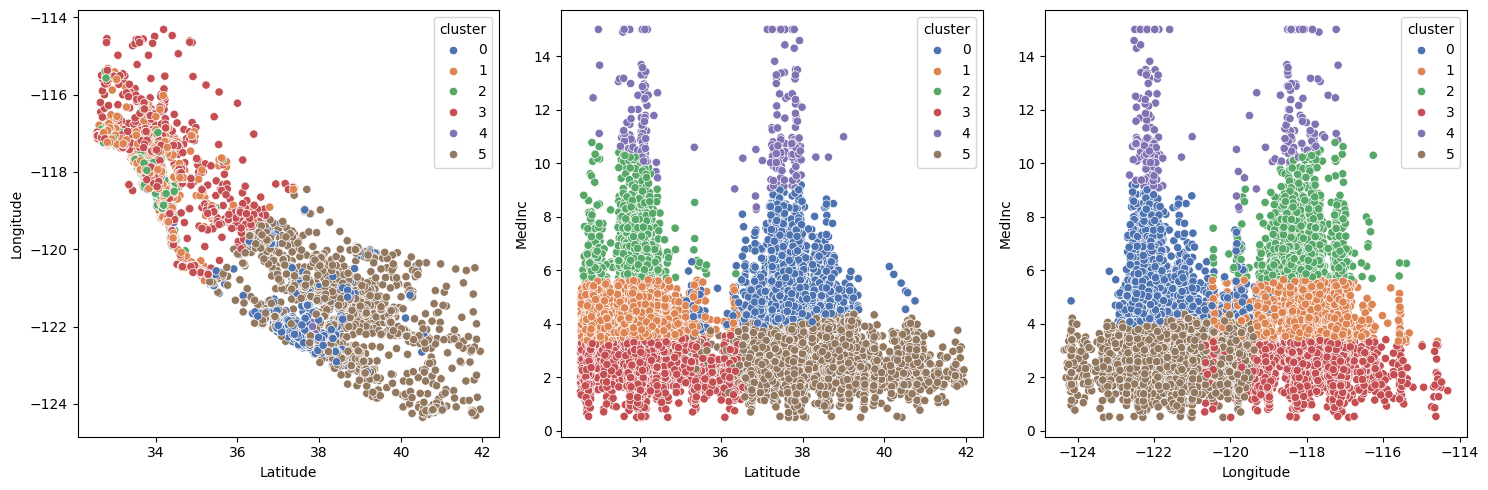

In [7]:
fig, axis = plt.subplots(1, 3, figsize = (15, 5))

sns.scatterplot(ax = axis[0], data = X_train, x = "Latitude", y = "Longitude", hue = "cluster", palette = "deep")
sns.scatterplot(ax = axis[1], data = X_train, x = "Latitude", y = "MedInc", hue = "cluster", palette = "deep")
sns.scatterplot(ax = axis[2], data = X_train, x = "Longitude", y = "MedInc", hue = "cluster", palette = "deep")
plt.tight_layout()

plt.show()

In [8]:
y_test = list(model_unsup.predict(X_test))
X_test["cluster"] = y_test
X_test.head()

,MedInc,Latitude,Longitude,cluster
20046,1.6812,36.06,-119.01,3
3024,2.5313,35.14,-119.46,3
15663,3.4801,37.80,-122.44,5
20484,5.7376,34.28,-118.72,2
9814,3.7250,36.62,-121.93,5


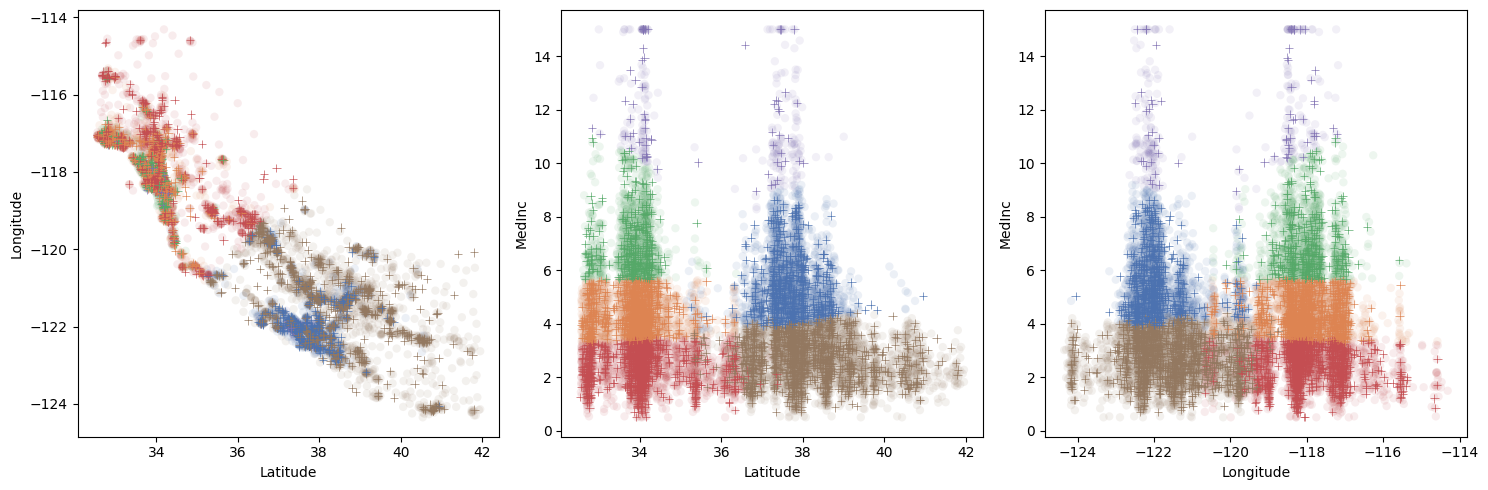

In [9]:
fig, axis = plt.subplots(1, 3, figsize = (15, 5))

sns.scatterplot(ax = axis[0], data = X_train, x = "Latitude", y = "Longitude", hue = "cluster", palette = "deep", alpha  = 0.1)
sns.scatterplot(ax = axis[1], data = X_train, x = "Latitude", y = "MedInc", hue = "cluster", palette = "deep", alpha  = 0.1)
sns.scatterplot(ax = axis[2], data = X_train, x = "Longitude", y = "MedInc", hue = "cluster", palette = "deep", alpha  = 0.1)

sns.scatterplot(ax = axis[0], data = X_test, x = "Latitude", y = "Longitude", hue = "cluster", palette = "deep", marker = "+")
sns.scatterplot(ax = axis[1], data = X_test, x = "Latitude", y = "MedInc", hue = "cluster", palette = "deep", marker = "+")
sns.scatterplot(ax = axis[2], data = X_test, x = "Longitude", y = "MedInc", hue = "cluster", palette = "deep", marker = "+")

plt.tight_layout()

for ax in axis:
    ax.legend([],[], frameon=False)

plt.show()

In [10]:
model_sup = DecisionTreeClassifier(random_state = 42)
model_sup.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

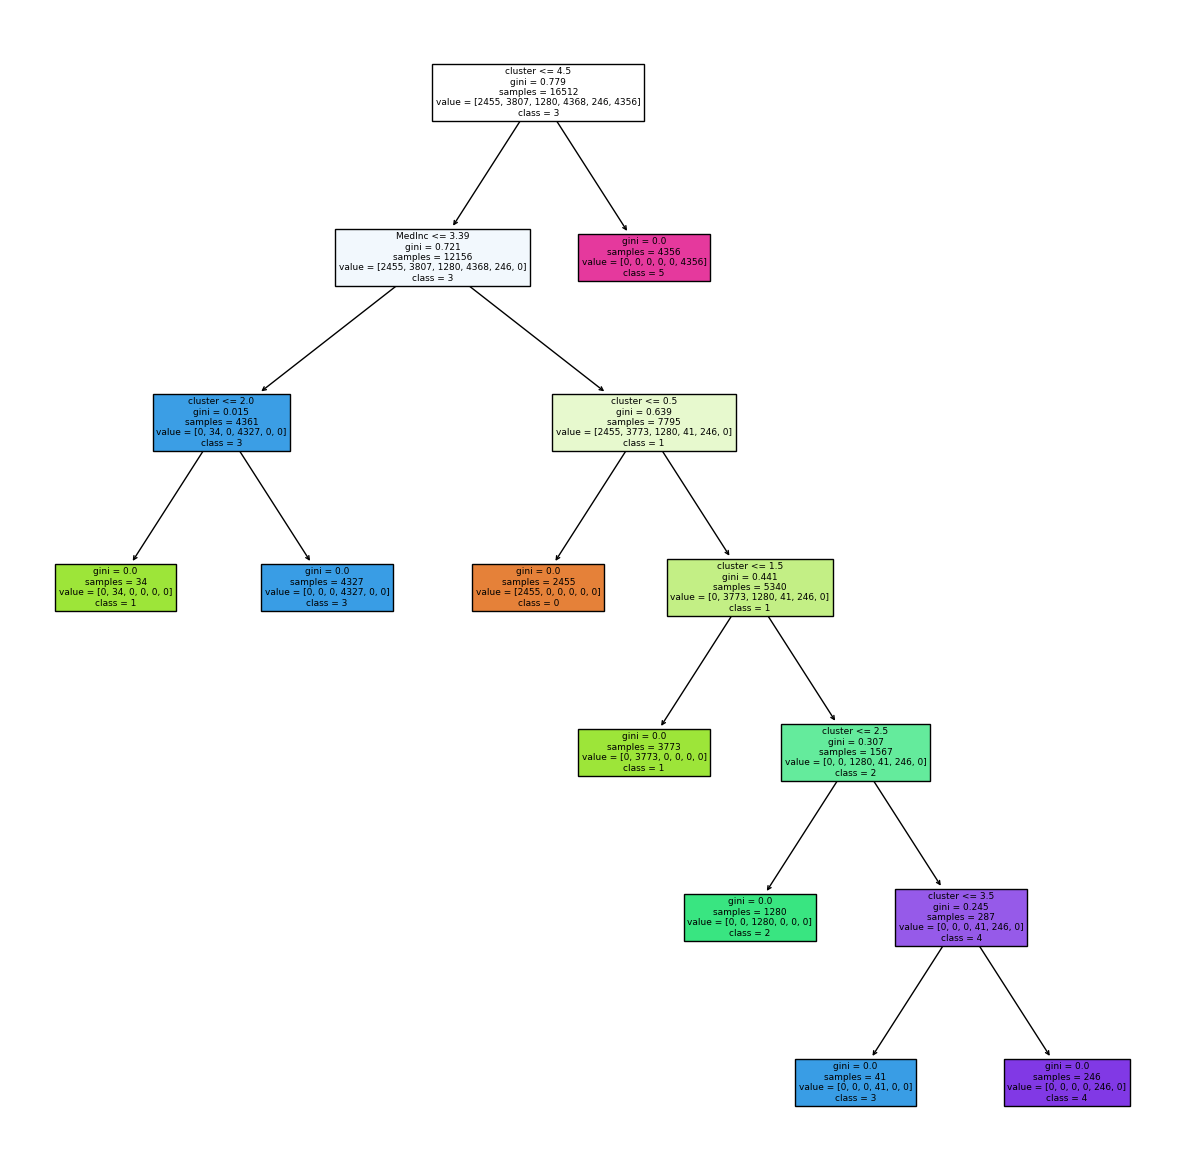

In [11]:
fig = plt.figure(figsize=(15,15))

tree.plot_tree(model_sup, feature_names = list(X_train.columns), class_names = ["0", "1", "2", "3", "4", "5"], filled = True)

plt.show()

In [12]:
y_pred = model_sup.predict(X_test)
y_pred

array([3, 3, 5, ..., 4, 5, 1], dtype=int32)

In [13]:
accuracy_score(y_test, y_pred)

1.0